In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import verde as vd
import pyproj
import pygmt
import eqs_magnetics as eqs
import harmonica as hm
import itertools
import synthetics
import warnings

In [2]:
# Suppress some scikit-learn warning that isn't valid
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

## Load ICEGRAV

In [3]:
icegrav = pd.read_table(
    '../data/ICEGRAV_Mag_2013_v2.XYZ',
    delim_whitespace=True,
    na_values="*",
    dtype={'Line_Number':str}
)
icegrav.dropna(subset=('Lon', 'Lat'), inplace=True)

In [4]:
projection = pyproj.Proj(projparams='+proj=ups +south', preserve_units=False)
x,y = projection(icegrav.Lon, icegrav.Lat)
coordinates = [x, y]
coordinates.append(np.full_like(coordinates[0], icegrav.Height_WGS1984))

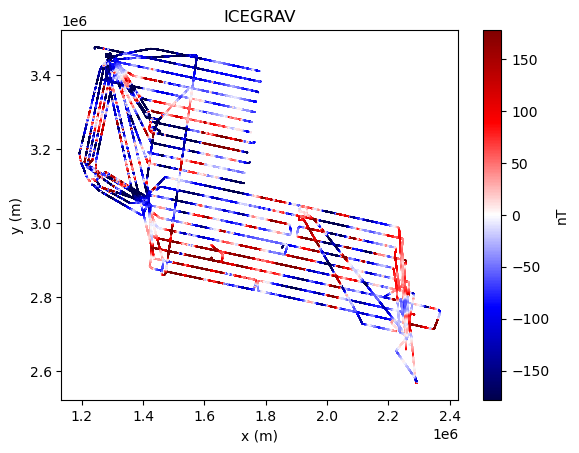

In [5]:
plt.figure()
scale = np.nanpercentile(icegrav.MagL, 95)
plt.scatter(*coordinates[:2], c=icegrav.MagL, cmap="seismic",s=0.01, vmin=-scale, vmax=scale)
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.colorbar(label="nT")
plt.title("ICEGRAV")
plt.show()

## Synthetic

In [6]:
region = vd.get_region(coordinates)
grid_coordinates = vd.grid_coordinates(region, spacing=1e4, extra_coords=3e3)
field_direction = np.array([hm.magnetic_angles_to_vec(1, -65, 25)]).T

In [7]:
source_coordinates, dipole_moments = synthetics.icegrav_synthetic(
    source1=[-60, 60],
    source2=[60,60],
    source3=[-60,60],
    source4=[60,60],
    source5=[60,60],
    source6=[-60,60],
    source7=[60,60],
    source8=[60,60],
    source9=[-80,80],
    regional=[-70,30]   
)

In [8]:
b_synthetic = eqs.dipole_magnetic(coordinates, source_coordinates, dipole_moments)
tfa_synthetic = eqs.total_field_anomaly(b_synthetic, field_direction)
bnorm_synthetic = eqs.magnetic_field_norm(b_synthetic)

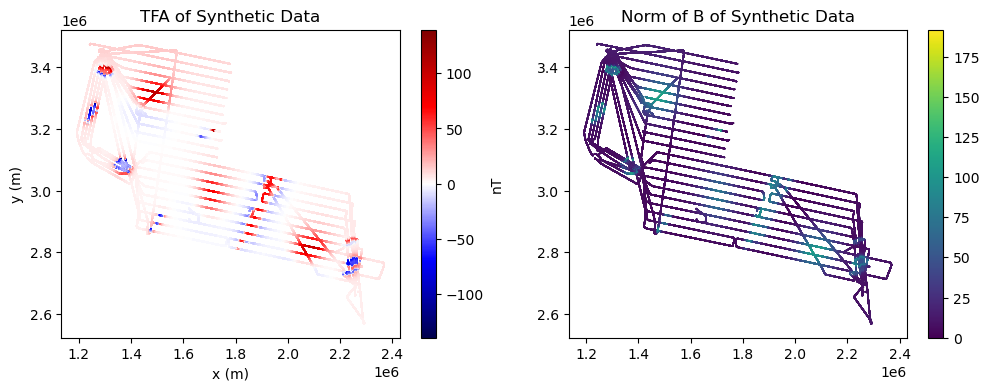

In [9]:
plt.figure(figsize=(12,4))
scale = vd.maxabs(tfa_synthetic)
plt.subplot(1,2,1)
plt.scatter(*coordinates[:2], c=tfa_synthetic, cmap="seismic",s=0.01, vmin=-scale, vmax=scale)
plt.title("TFA of Synthetic Data")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.colorbar(label="nT")
scale = vd.maxabs(bnorm_synthetic)
plt.subplot(1,2,2)
plt.scatter(*coordinates[:2], c=bnorm_synthetic, cmap="viridis",s=0.01, vmin=0, vmax=scale)
plt.title("Norm of B of Synthetic Data")
plt.colorbar()
plt.show()

## Fit deep sources

In [10]:
spacing = 5e4
reducer = vd.BlockReduce(reduction=np.median, spacing=spacing, region=(vd.pad_region(vd.get_region(coordinates), pad=spacing*0.5)), drop_coords=False)
# Use the filter method to apply the reduction:
coords_blocked, tfa_blocked = reducer.filter(coordinates, data=tfa_synthetic)

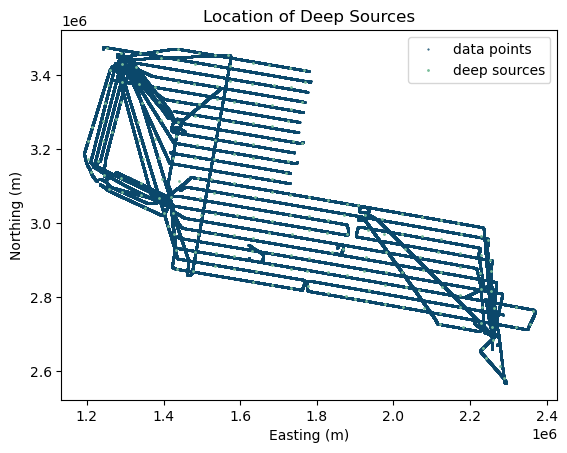

In [11]:
plt.figure()
plt.plot(*coordinates[:2], ".", color="#0B486B", markersize=1, label='data points')
plt.plot(*coords_blocked[:2], ".", color="#79BD9A", markersize=2, label='deep sources')
plt.title("Location of Deep Sources")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.legend()
plt.show()

In [13]:
dampings_deep_eqs = [1e-2, 1e-1, 1e1, 1e2]
spacing = np.mean(vd.median_distance(coords_blocked))
depths_deep_eqs = [spacing*2.5, spacing*3.5, spacing*4.25, spacing*5, spacing*6]
# dampings = [1e-3]
# depths = [spacing*4.25]

In [14]:
parameter_sets_deep_eqs = [
    dict(damping=combo[0], depth=combo[1])
    for combo in itertools.product(dampings_deep_eqs, depths_deep_eqs)
]
print("Number of combinations:", len(parameter_sets_deep_eqs))

Number of combinations: 20


In [15]:
%%time
kfold = vd.BlockKFold(
    spacing=2500,
    shuffle=True,
    random_state=0,
    balance=True,
)
features = np.transpose(coords_blocked[:2])
scores = []
damping = []
source_depth = []
for parameters in parameter_sets_deep_eqs:    
    print(parameters)
    eqs_deep = eqs.EquivalentSourcesMagnetic(block_size=1e3, **parameters)
    tmp = []
    for train, test in kfold.split(features):
        eqs_deep.fit(
            [c[train] for c in coords_blocked], 
            tfa_blocked[train], 
            field_direction,
        )
        predicted = eqs.total_field_anomaly(
            eqs_deep.predict([c[test] for c in coords_blocked]),
            field_direction,
        )
        tmp.append(np.linalg.norm(tfa_blocked[test] - predicted))
    scores.append(np.mean(tmp))
    damping.append(parameters['damping'])
    source_depth.append(parameters['depth'])

{'damping': 0.01, 'depth': 91779.65816847704}
{'damping': 0.01, 'depth': 128491.52143586785}
{'damping': 0.01, 'depth': 156025.41888641095}
{'damping': 0.01, 'depth': 183559.31633695407}
{'damping': 0.01, 'depth': 220271.17960434488}
{'damping': 0.1, 'depth': 91779.65816847704}
{'damping': 0.1, 'depth': 128491.52143586785}
{'damping': 0.1, 'depth': 156025.41888641095}
{'damping': 0.1, 'depth': 183559.31633695407}
{'damping': 0.1, 'depth': 220271.17960434488}
{'damping': 10.0, 'depth': 91779.65816847704}
{'damping': 10.0, 'depth': 128491.52143586785}
{'damping': 10.0, 'depth': 156025.41888641095}
{'damping': 10.0, 'depth': 183559.31633695407}
{'damping': 10.0, 'depth': 220271.17960434488}
{'damping': 100.0, 'depth': 91779.65816847704}
{'damping': 100.0, 'depth': 128491.52143586785}
{'damping': 100.0, 'depth': 156025.41888641095}
{'damping': 100.0, 'depth': 183559.31633695407}
{'damping': 100.0, 'depth': 220271.17960434488}
CPU times: user 4min 31s, sys: 2min 10s, total: 6min 41s
Wall ti

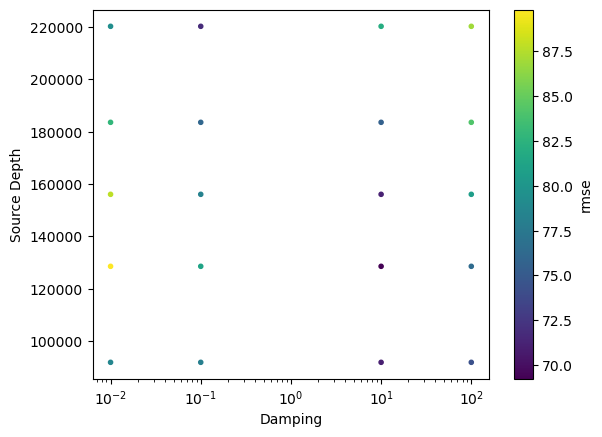

In [16]:
plt.figure()
plt.scatter(
    damping,
    source_depth,
    c=scores,
    cmap="viridis",
    marker='.',
    vmax= np.percentile(scores,99),
)
plt.xlabel('Damping')
plt.ylabel('Source Depth')
plt.xscale('log')
plt.colorbar(label='rmse')
plt.show()

In [17]:
best = np.argmin(scores)
parameter_sets_deep_eqs[best]

{'damping': 10.0, 'depth': 128491.52143586785}

In [18]:
%%time
eqs_deep = eqs.EquivalentSourcesMagnetic(**parameter_sets_deep_eqs[best])
eqs_deep.fit(coords_blocked, tfa_blocked, field_direction)
print("source height:", eqs_deep.dipole_coordinates_[2][0])

source height: -125607.37143586786
CPU times: user 892 ms, sys: 105 ms, total: 997 ms
Wall time: 269 ms


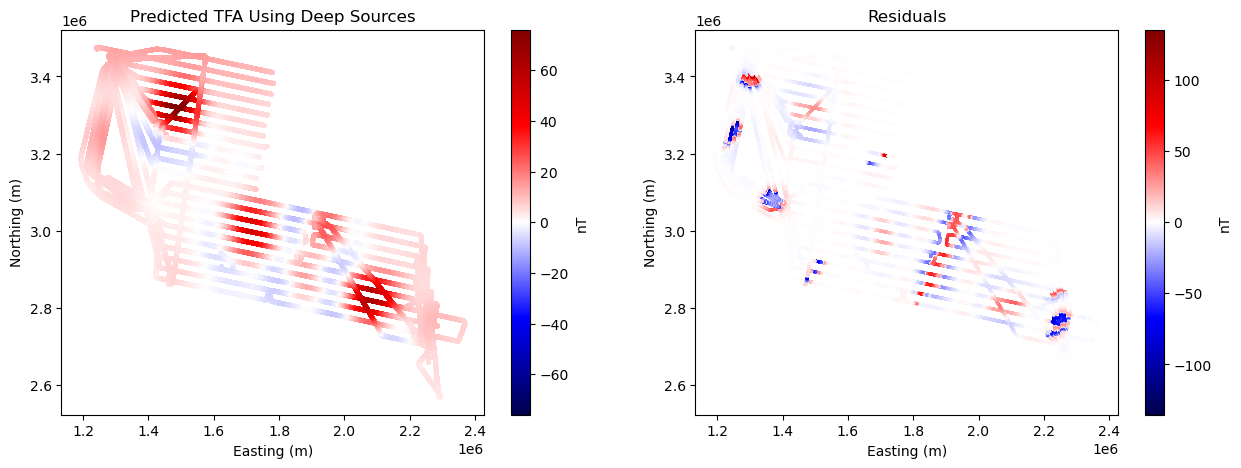

In [19]:
tfa_deep_blocked = eqs.total_field_anomaly(eqs_deep.predict(coords_blocked), field_direction)
tfa_deep = eqs.total_field_anomaly(eqs_deep.predict(coordinates), field_direction)
tfa_residuals = tfa_synthetic - tfa_deep

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
scale = vd.maxabs(tfa_deep)
plt.scatter(*coordinates[:2], c=tfa_deep, cmap="seismic", s=5, vmin=-scale, vmax=scale)
plt.title("Predicted TFA Using Deep Sources")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

plt.subplot(1,2,2)
scale = vd.maxabs(tfa_residuals)
plt.scatter(*coordinates[:2], c=tfa_residuals, cmap="seismic", s=1, vmin=-scale, vmax=scale)
plt.title("Residuals")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")
plt.show()

## Fit the deep residuals with gradient-boosted sources

In [40]:
dampings_shallow_eqs = [1e1, 1e2, 1e3, 1e4, 1e5]
# depths_shallow_eqs = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
depths_shallow_eqs = [500, 800]

In [41]:
parameter_sets_shallow_eqs = [
    dict(damping=combo[0], depth=combo[1])
    for combo in itertools.product(dampings_shallow_eqs, depths_shallow_eqs)
]
print("Number of combinations:", len(parameter_sets_shallow_eqs))

Number of combinations: 10


In [42]:
print(str(list(parameter_sets_shallow_eqs)[0])[12:16])
print(str(parameter_sets_shallow_eqs)[0][27:30])

10.0



In [43]:
%%time
kfold = vd.BlockKFold(
    spacing=1e5,
    shuffle=True,
    random_state=0,
    balance=True,
)
features = np.transpose(coordinates[:2])
scores = []
damping = []
source_depth = []
for parameters in parameter_sets_shallow_eqs:    
    print(parameters)
    eqs_shallow = eqs.EquivalentSourcesMagneticGB(random_state=0, block_size=1e3, **parameters)
    tmp = []
    for train, test in kfold.split(features):
        eqs_shallow.fit(
            [c[train] for c in coordinates], 
            tfa_residuals[train], 
            field_direction,
        )
        predicted = eqs.total_field_anomaly(
            eqs_shallow.predict([c[test] for c in coordinates]),
            field_direction,
        )
        tmp.append(np.linalg.norm(tfa_residuals[test] - predicted))
    scores.append(np.mean(tmp))
    damping.append(parameters['damping'])
    source_depth.append(parameters['depth'])

{'damping': 10.0, 'depth': 500}
{'damping': 10.0, 'depth': 800}
{'damping': 100.0, 'depth': 500}
{'damping': 100.0, 'depth': 800}
{'damping': 1000.0, 'depth': 500}
{'damping': 1000.0, 'depth': 800}
{'damping': 10000.0, 'depth': 500}
{'damping': 10000.0, 'depth': 800}
{'damping': 100000.0, 'depth': 500}
{'damping': 100000.0, 'depth': 800}
CPU times: user 12h 18min 6s, sys: 1h 50min 9s, total: 14h 8min 15s
Wall time: 43min 2s


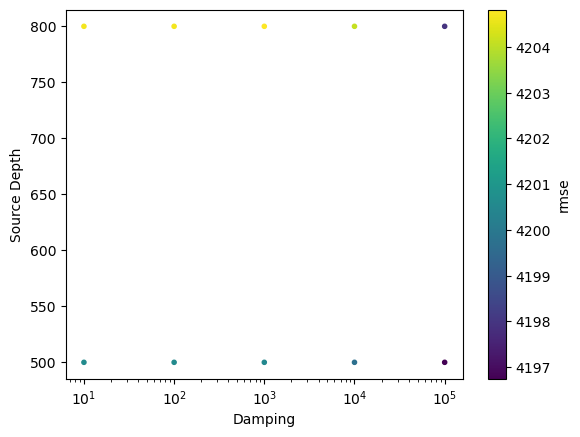

In [44]:
plt.figure()
plt.scatter(
    damping,
    source_depth,
    c=scores,
    cmap="viridis",
    marker='.',
    vmax= np.percentile(scores,99),
)
plt.xlabel('Damping')
plt.ylabel('Source Depth')
plt.xscale('log')
plt.colorbar(label='rmse')
plt.show()

In [45]:
best = np.argmin(scores)
parameter_sets_shallow_eqs[best]

{'damping': 100000.0, 'depth': 500}

In [46]:
%%time
eqs_shallow = eqs.EquivalentSourcesMagneticGB(random_state=0, block_size=1e4, **parameter_sets_shallow_eqs[best], repeat=2)
eqs_shallow.fit(coordinates, tfa_residuals, field_direction)
print("dipole height:", eqs_shallow.dipole_coordinates_[2][0])
print("window size:", eqs_shallow.window_size_)

dipole height: 2387.7
window size: 114869.41642621873
CPU times: user 14min 2s, sys: 3min 38s, total: 17min 41s
Wall time: 30.9 s


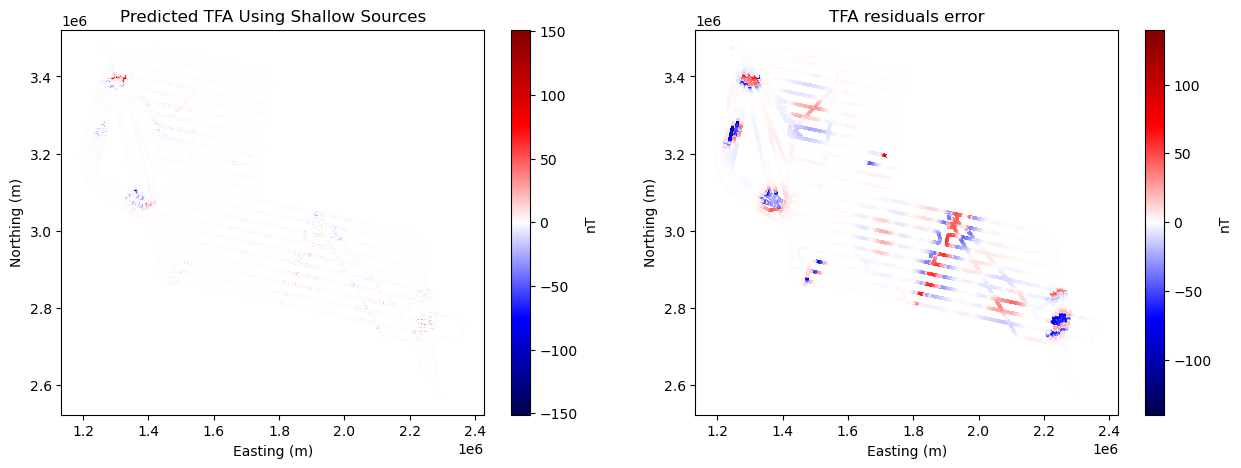

In [47]:
tfa_residuals_prediction = eqs.total_field_anomaly(eqs_shallow.predict(coordinates), field_direction)

plt.figure(figsize=(15,5))
scale = vd.maxabs(tfa_residuals_prediction)
plt.subplot(1,2,1)
plt.scatter(*coordinates[:2], c=tfa_residuals_prediction, cmap="seismic", s=1, vmin=-scale, vmax=scale)
plt.title("Predicted TFA Using Shallow Sources")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

plt.subplot(1,2,2)
scale = vd.maxabs(tfa_residuals - tfa_residuals_prediction)
plt.scatter(*coordinates[:2], c=tfa_residuals - tfa_residuals_prediction, cmap="seismic", s=1, vmin=-scale, vmax=scale)
plt.title("TFA residuals error")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")
plt.show()

## Predict on a regular grid

In [48]:
grid_coordinates = vd.grid_coordinates(vd.get_region(coordinates), spacing=1e3, extra_coords=3e3)

true_b = eqs.dipole_magnetic(grid_coordinates, source_coordinates, dipole_moments)
true_tfa = eqs.total_field_anomaly(true_b, field_direction)

predicted_b = eqs_deep.predict(grid_coordinates) + eqs_shallow.predict(grid_coordinates)
predicted_tfa = eqs.total_field_anomaly(predicted_b, field_direction)
error_tfa = true_tfa - predicted_tfa

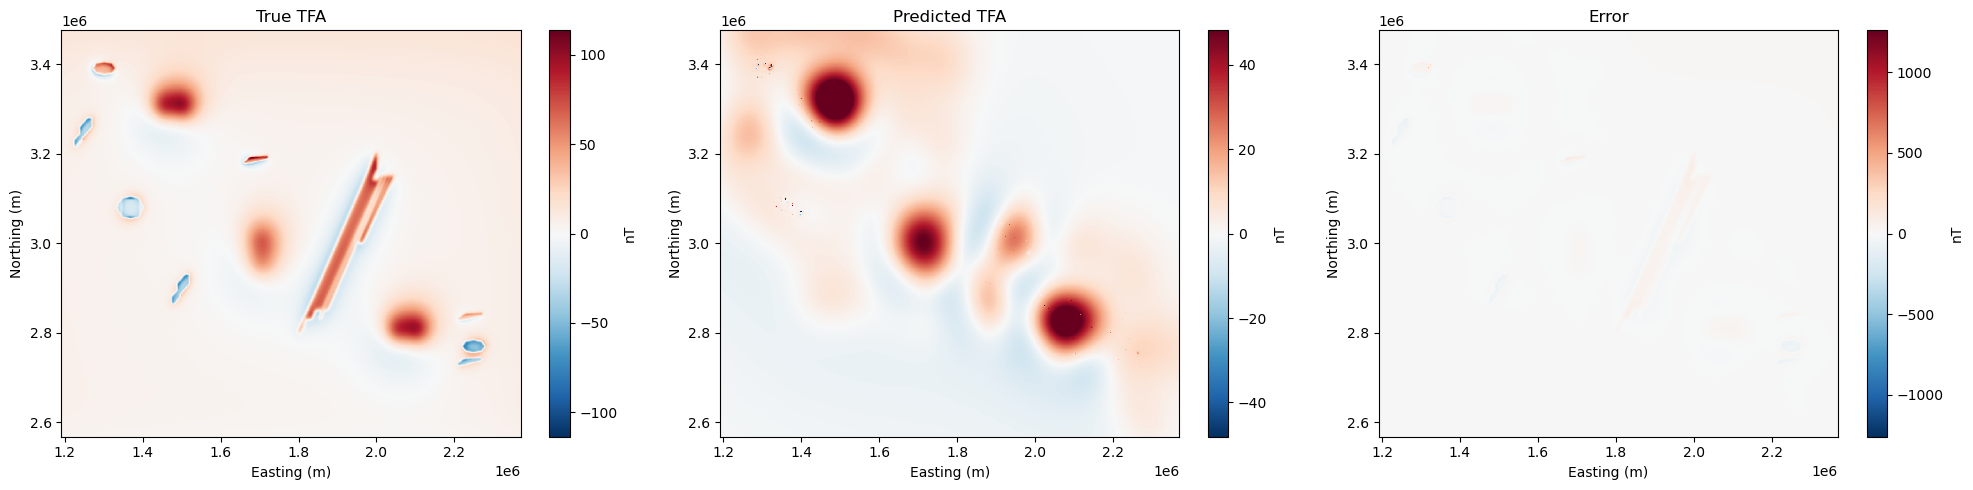

In [49]:
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
scale = vd.maxabs(true_tfa)
plt.pcolormesh(*grid_coordinates[:2], true_tfa, cmap="RdBu_r", vmin=-scale, vmax=scale)
plt.title("True TFA")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

plt.subplot(1,3,2)
scale = vd.maxabs(predicted_tfa)
scale = np.nanpercentile(predicted_tfa, 99)
plt.pcolormesh(*grid_coordinates[:2], predicted_tfa, cmap="RdBu_r", vmin=-scale, vmax=scale)
plt.title("Predicted TFA")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

plt.subplot(1,3,3)
scale = vd.maxabs(error_tfa)
plt.pcolormesh(*grid_coordinates[:2], error_tfa, cmap="RdBu_r", vmin=-scale, vmax=scale)
plt.title("Error")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")
plt.tight_layout()
plt.show()

In [50]:
true_norm_of_b = np.sqrt(sum(c**2 for c in true_b))
predicted_norm_of_b = np.sqrt(sum(c**2 for c in predicted_b))
error_norm_of_b = true_norm_of_b - predicted_norm_of_b

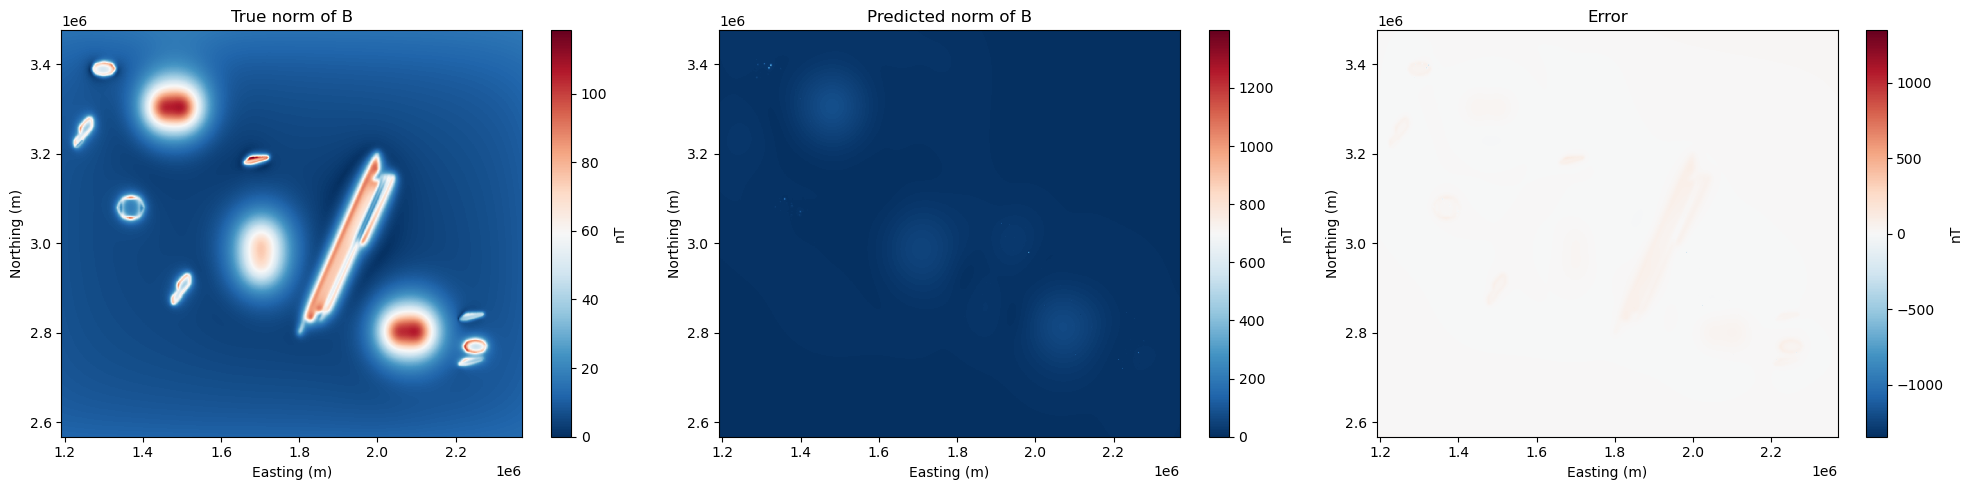

In [51]:
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
scale = vd.maxabs(true_norm_of_b)
plt.pcolormesh(*grid_coordinates[:2], true_norm_of_b, cmap="RdBu_r", vmin=0, vmax=scale)
plt.title("True norm of B")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

plt.subplot(1,3,2)
scale = vd.maxabs(predicted_norm_of_b)
plt.pcolormesh(*grid_coordinates[:2], predicted_norm_of_b, cmap="RdBu_r", vmin=0, vmax=scale)
plt.title("Predicted norm of B")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

plt.subplot(1,3,3)
scale = vd.maxabs(error_norm_of_b)
plt.pcolormesh(*grid_coordinates[:2], error_norm_of_b, cmap="RdBu_r", vmin=-scale, vmax=scale)
plt.title("Error")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")
plt.tight_layout()
plt.show()